# Preparação e tratamento dos dados - Parte 2

## Objetivo

Este código tem como objetivo tratar a base "ans.csv" desenvolvida na parte 1

As etapas abordadas no tratamento de dados desenvolvido neste código são as seguintes:

1. Filtragem por tipo de contratação, porte e modalidade de operadora
1. Agrupamento das informações de receita, despesa e total de beneficiarios
1. Identificação e tratamento de dados outliers de receita e despesa
1. Criação da base para ser utilizada na etapa de forecast

## Este código aborda as informações do seguinte segmento:

### Individual - Modalidade Medicina de Grupo

In [56]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.6f}'.format

In [57]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def sum_thousand(x):    
    return round(((x.sum())/1000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

### Seleção do Período para o tratamento dos dados

In [58]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

### Parametros para filtragem dos dados

In [59]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Individual'

tipo_modalidade = 'Medicina de Grupo'

## Leitura dos dados

Carregamento e leitura da base desenvolvida na parte 1 do código

In [60]:
path = f'D:/TCC/tcc-main/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

#modificando os tipos de dados

ans['ano'] = ans['ano'].astype('str')

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

#Filtrando os dados até 2021
ans = ans[(ans.ano < '2022')]

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

#Filtra somente as operadas com flag ativas
ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.head()


,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2017,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2017,2017Q3,2095967.190000,0.000000,747.000000,0.0,0.0
1,2017,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/12/2017,2017Q4,785491.930000,0.000000,719.000000,0.0,0.0
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/03/2018,2018Q1,791860.200000,0.000000,722.000000,0.0,0.0
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2018,2018Q2,769499.340000,0.000000,731.000000,0.0,0.0
4,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2018,2018Q3,846654.020000,0.000000,774.000000,0.0,0.0


In [61]:
#Filtra o segmento abordado neste código
ans_filt_cont_mod = ans_filt[ (ans_filt['contratacao'] == tipo_contratacao) & 
                              (ans_filt['modalidade'] == tipo_modalidade)].reset_index(drop=True)

ans_filt_cont_mod = ans_filt_cont_mod[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_cont_mod.head()

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,trimestre,receita,despesa,benef
0,2017,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Individual,Pre-estabelecido,2017Q3,1159356.520000,9963350.540000,770.000000
1,2017,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Individual,Pre-estabelecido,2017Q4,426371.820000,3711758.760000,757.000000
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Individual,Pre-estabelecido,2018Q1,424149.790000,3714030.960000,754.000000
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Individual,Pre-estabelecido,2018Q2,415687.570000,3568938.250000,727.000000
4,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Individual,Pre-estabelecido,2018Q3,443697.220000,3945535.370000,709.000000


In [62]:
ans_filt_cont_mod[['ano','cd_ops','trimestre','receita','despesa','benef','modalidade','port_ops','contratacao']].to_csv('ind_medgrupo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_filt_cont_mod.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

receita    despesa
ano  cd_ops razao_social                                                  trimestre                      
2017 300012 CEMIL CENTRO MEDICO DE ITU LTDA.                              2017Q3      1.160000   9.960000
                                                                          2017Q4      0.430000   3.710000
     301728 PRONTOMED PLANOS DE SAÚDE LTDA                                2017Q3      0.080000   0.090000
                                                                          2017Q4      0.030000   0.030000
     302091 SÃO FRANCISCO SISTEMAS DE SAÚDE SOCIEDADE EMPRESÁRIA LIMITADA 2017Q3    193.410000 106.240000

### Agregação dos valores de receita e despesa e quantidade de beneficiarios

In [63]:
ans_filt_cont_mod_agrup = ans_filt_cont_mod.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_billion(x),
                                                                                               'despesa':lambda x: sum_billion(x),
                                                                                               'benef': 'sum',
                                                                                               'cd_ops':lambda x: x.nunique()})

ans_filt_cont_mod_agrup['ind_sinistralidade'] = ans_filt_cont_mod_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_cont_mod_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','ind_sinistralidade']

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[['trimestre','receita','despesa','benef','n_ops','ind_sinistralidade']]

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[(ans_filt_cont_mod_agrup.trimestre > '2017Q3') & (ans_filt_cont_mod_agrup.trimestre < '2022Q1')]

ans_filt_cont_mod_agrup[['n_ops','benef']] = ans_filt_cont_mod_agrup[['n_ops','benef']].astype('int')

ans_filt_cont_mod_agrup.set_index('trimestre', inplace=True)

ans_filt_cont_mod_agrup

,receita,despesa,benef,n_ops,ind_sinistralidade
trimestre,,,,,
2017Q4,3.640000,2.620000,3372376,158,71.980000
2018Q1,3.680000,2.480000,3390268,160,67.390000
2018Q2,3.820000,2.710000,3441493,162,70.940000
2018Q3,3.940000,3.000000,3457430,167,76.140000
2018Q4,4.180000,2.910000,3517626,165,69.620000
2019Q1,4.170000,2.960000,3518036,168,70.980000
2019Q2,4.260000,3.260000,3563719,170,76.530000
2019Q3,4.300000,3.340000,3604403,176,77.670000
2019Q4,4.610000,3.240000,3621734,174,70.280000


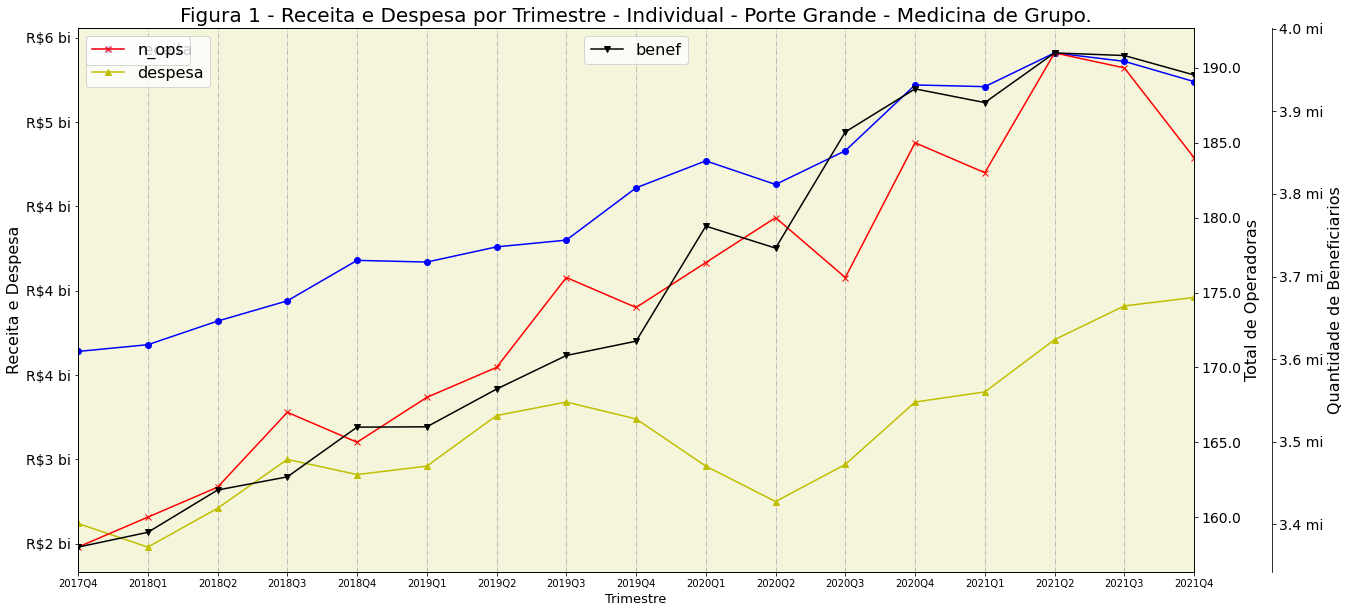

In [64]:
df_plot = ans_filt_cont_mod_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Individual - Porte Grande - Medicina de Grupo.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1000000) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [65]:
#Cria o ranking das operadoras com maior receita e despesa
ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                           'despesa':lambda x: sum_million(x),
                                                                                                           'benef': 'sum'}).reset_index(drop=True)

ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod_agrup_ops.sort_values(['benef'],ascending = False).groupby('trimestre').head(100).reset_index(drop=True)

#ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','benef'], ascending=[True,False], inplace=True)

ans_filt_cont_mod_agrup_ops.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2021,368253,2021Q4,826.070000,375.250000,931755.000000
1,2021,368253,2021Q2,702.880000,268.520000,782173.000000
2,2021,368253,2021Q1,689.180000,250.130000,781818.000000
3,2021,368253,2021Q3,702.960000,300.290000,778929.000000
4,2020,368253,2020Q4,705.770000,284.580000,774872.000000


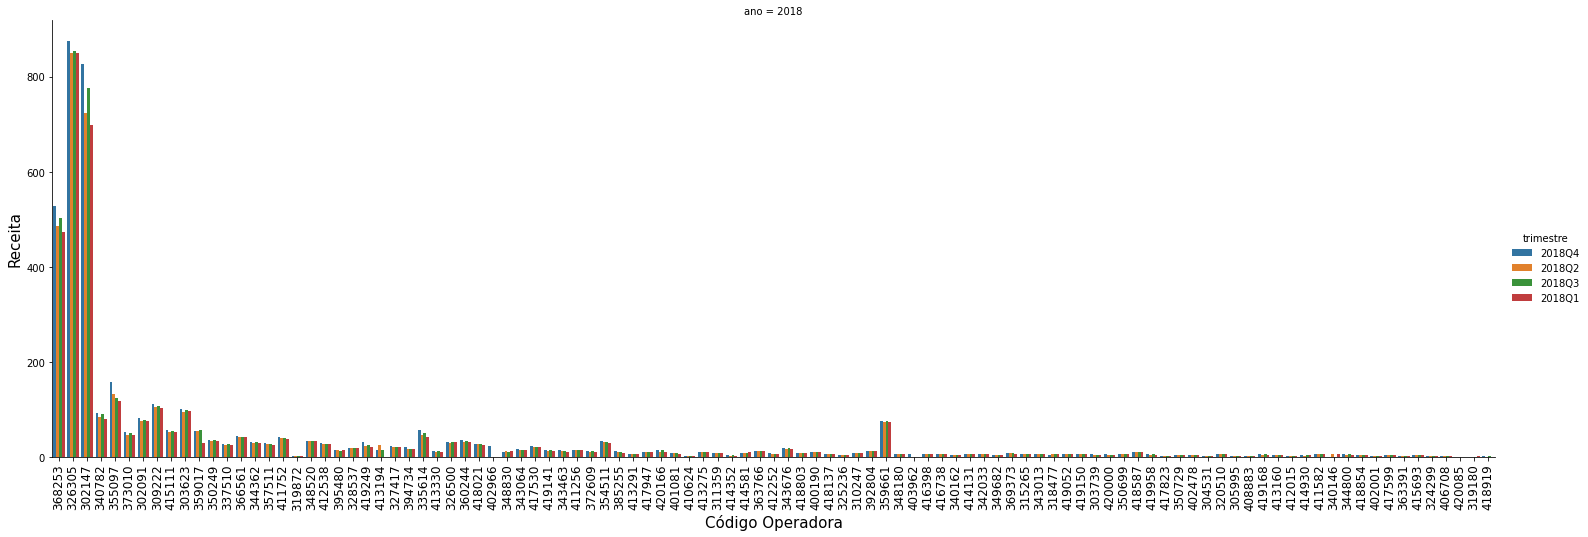

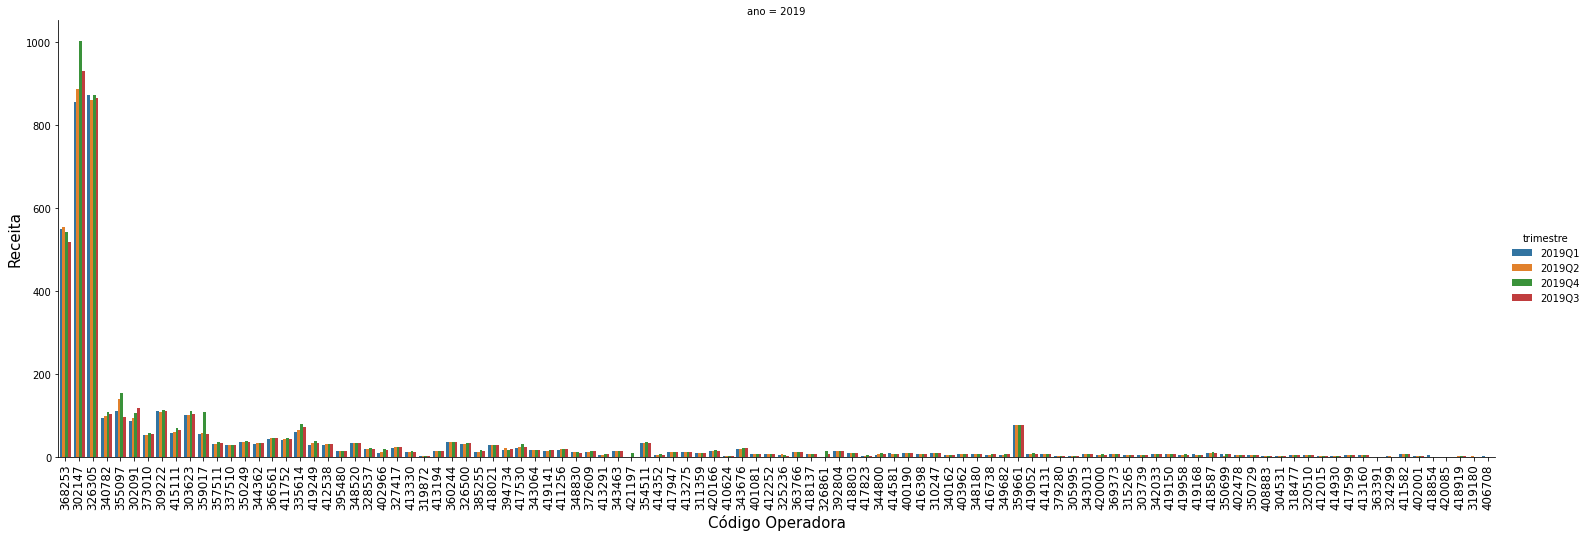

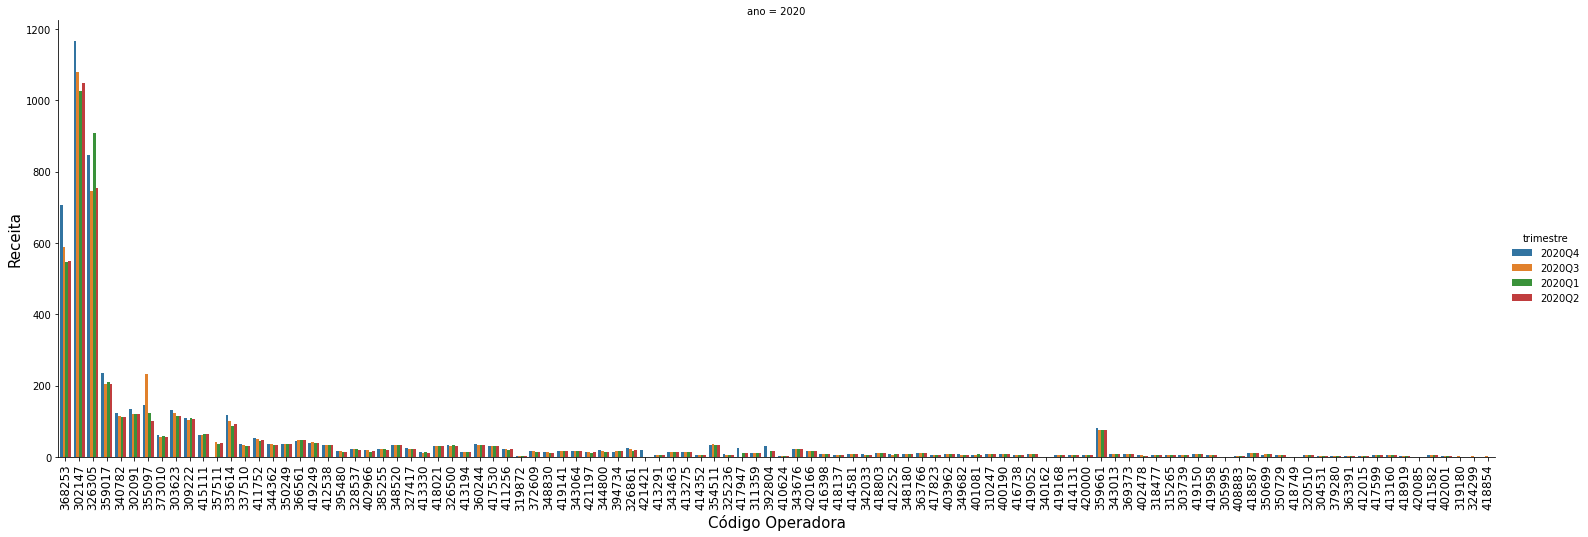

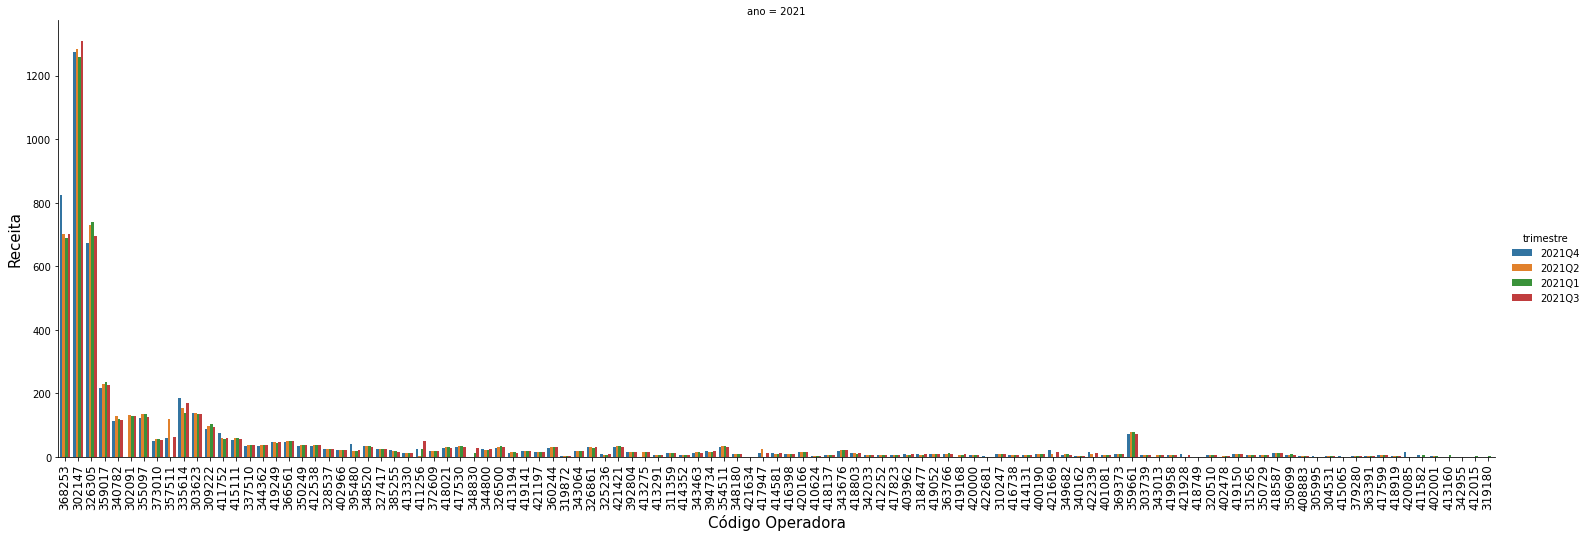

In [66]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

#ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

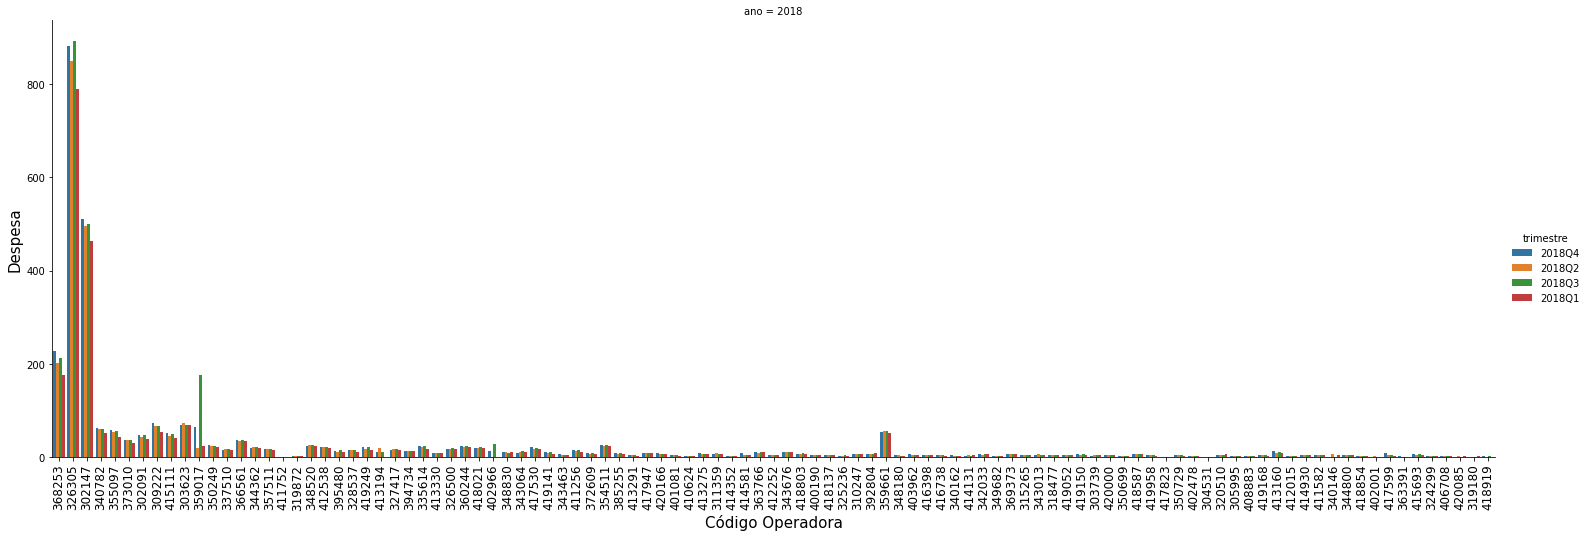

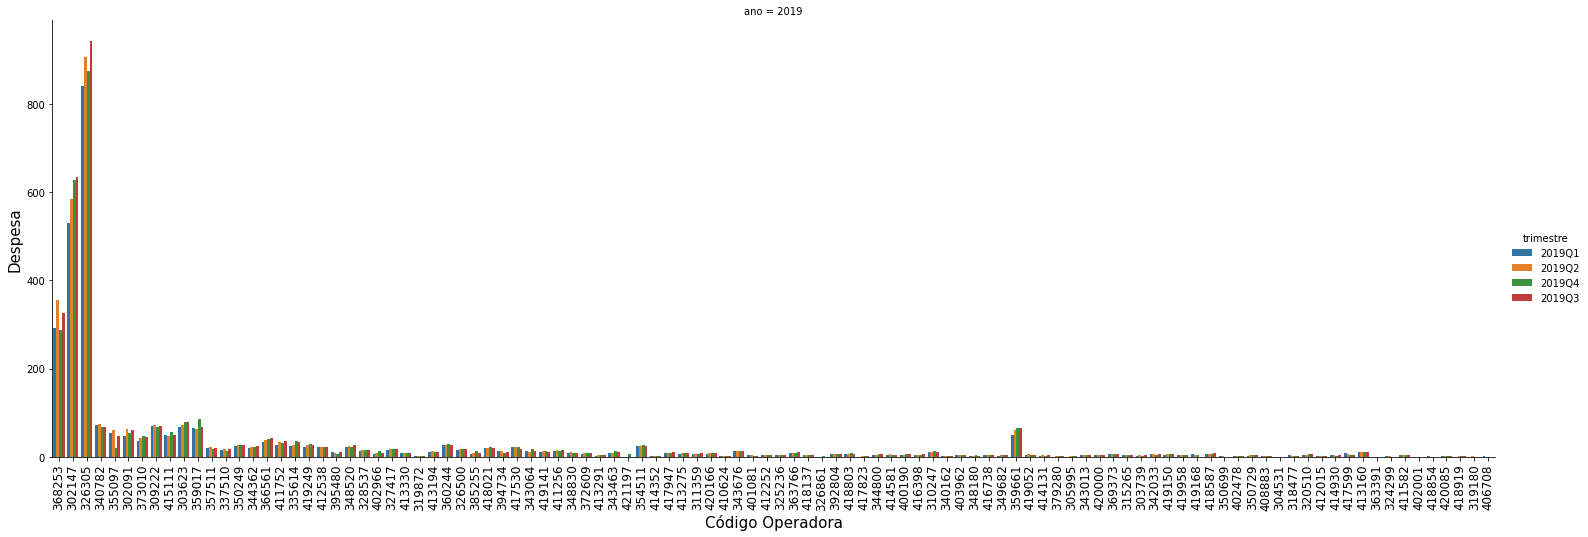

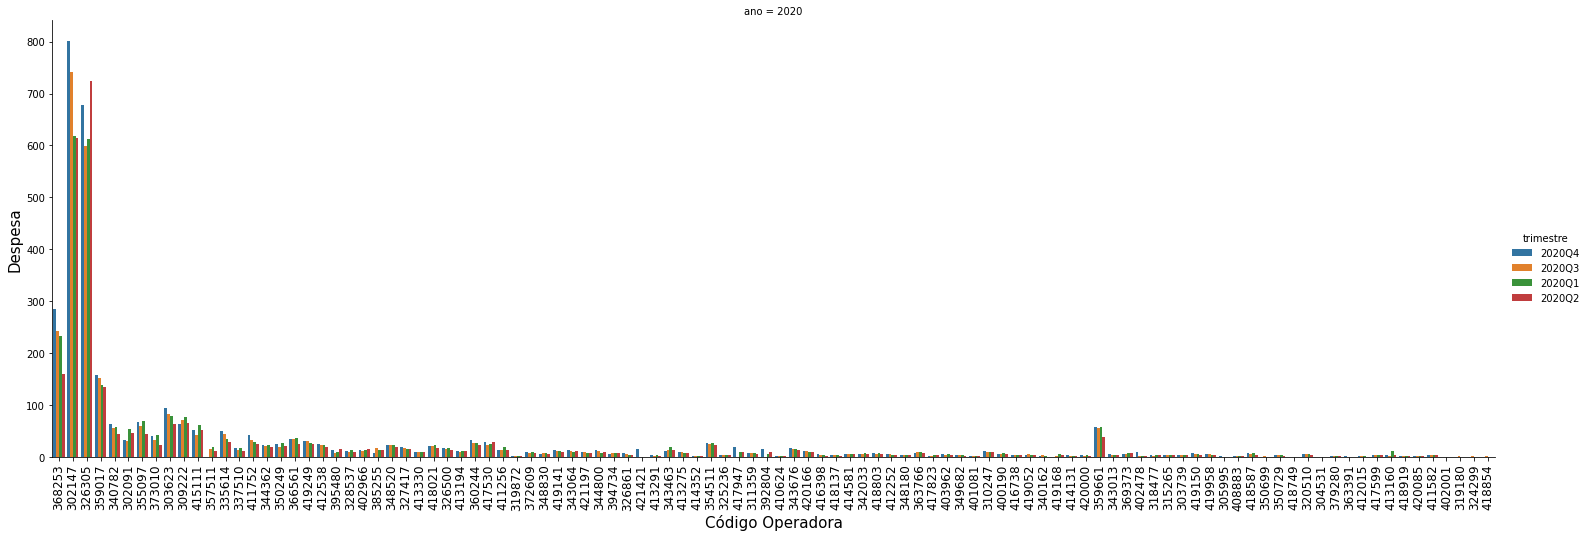

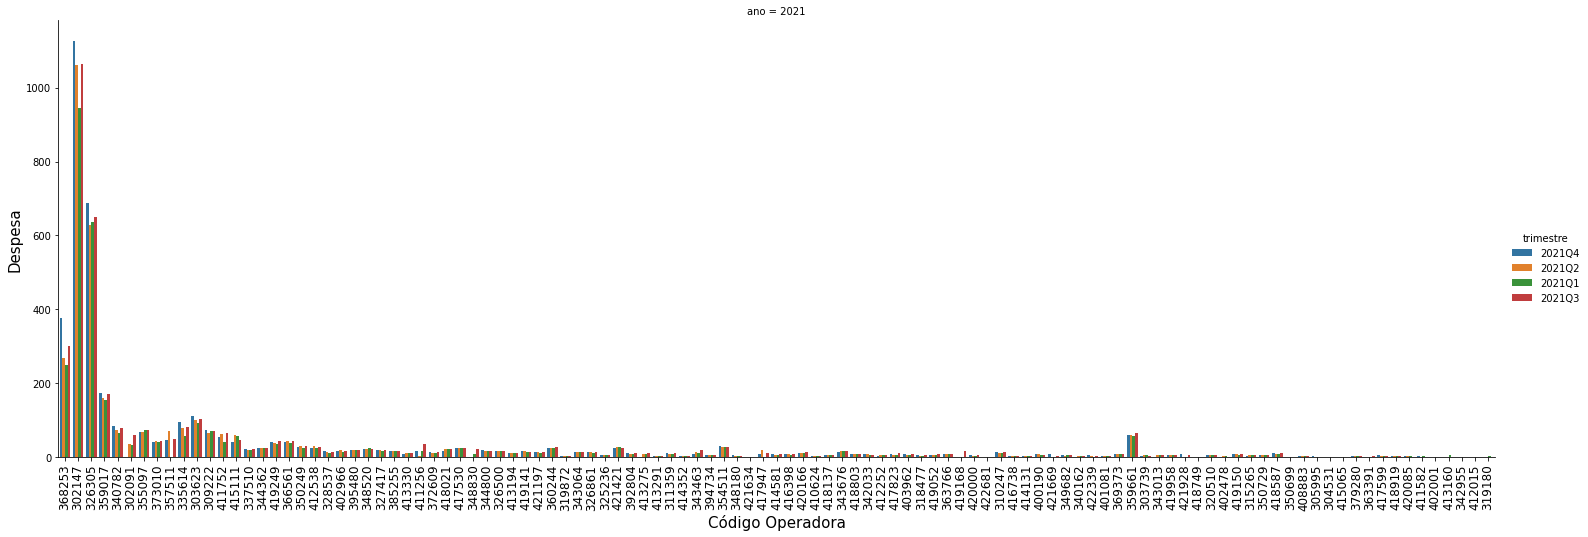

In [67]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### Limpeza e Tratamento de Dados dos outliers

Nos gráficos acima é possivel observar que as curvas de receita e despesas possuem pontos outliers, provavelmente ocasionados pelo por erros de lançamentos das demonstrações contabeis.

E além disso, nos gráficos de barras por operadoras, mostra que muitas operadoras não possuem lançamentos em todos os trimestres do ano. Essas ausencias de lançamentos também ajudam no aparecimento de pontos outliers na evolução trimestral de receita e despesa.

Os códigos das células abaixo, tem com objetivo corrigir essas falhas de lançamentos de demontrações contabeis trimestrais. E na última parte do tratamento, possui o objetivo de corrigir alguns desvios do da curva de receita e depesa trimestral.

#### 1ª Etapa - Preenchendo lançamentos faltantes de algumas operadoras

In [68]:
#Agrupamento da receita e despesa de cada operadora por trimestre
ans_alterada1 = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                             'despesa':'sum'})

ans_alterada1 = ans_alterada1[(ans_alterada1['ano']>'2017') & (ans_alterada1['ano']<'2022')] #Filtra anos de 2018 até 2021

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita != 0) & (ans_alterada1.despesa == 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa != 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa == 0)].index)

display(ans_alterada1.head())

,ano,cd_ops,trimestre,receita,despesa
315,2018,300012,2018Q1,424149.790000,3714030.960000
316,2018,300012,2018Q2,415687.570000,3568938.250000
317,2018,300012,2018Q3,443697.220000,3945535.370000
318,2018,300012,2018Q4,460677.170000,4003376.200000
319,2018,301728,2018Q1,50926.860000,19552.320000


In [69]:
#Identificação das operadora que não possuem os 4 lançamentos contabeis durante o ano, ou seja, existem algumas operadoras que possuem falhas na publicação des demonstrações de contabilidade
ans_alterada2 = ans_alterada1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))

display(ans_alterada2.head())

ans_alterada2.n_trimestre.unique()

,ano,cd_ops,n_trimestre
0,2018,300012,4
1,2018,301728,4
2,2018,302091,4
3,2018,302147,4
4,2018,303623,4


array([4, 3, 1, 2], dtype=int64)

In [70]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
ans_alterada_complete = ans_alterada2[ans_alterada2['n_trimestre']==4].reset_index(drop=True)
ans_alterada_complete = ans_alterada_complete[['ano','cd_ops']]

display(ans_alterada_complete.info())

display(ans_alterada_complete.head())

#ans_alterada_complete[ans_alterada_complete['cd_ops']=='393321']

complete_ops_list = ans_alterada_complete['cd_ops'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     645 non-null    period[A-DEC]
 1   cd_ops  645 non-null    object       
dtypes: object(1), period[A-DEC](1)
memory usage: 10.2+ KB


None

,ano,cd_ops
0,2018,300012
1,2018,301728
2,2018,302091
3,2018,302147
4,2018,303623


In [71]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
ans_alterada_imcomplete = ans_alterada2[ans_alterada2['n_trimestre']!=4].reset_index(drop=True)
ans_alterada_imcomplete = ans_alterada_imcomplete[['ano','cd_ops']]

display(ans_alterada_imcomplete.info())

display(ans_alterada_imcomplete.head())

imcomplete_ops_list = ans_alterada_imcomplete['cd_ops'].to_numpy()

#ans_alterada_imcomplete[ans_alterada_imcomplete['cd_ops']=='393321']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     59 non-null     period[A-DEC]
 1   cd_ops  59 non-null     object       
dtypes: object(1), period[A-DEC](1)
memory usage: 1.0+ KB


None

,ano,cd_ops
0,2018,321338
1,2018,335657
2,2018,344443
3,2018,346471
4,2018,364592


In [72]:
diff_list = np.setdiff1d(complete_ops_list,imcomplete_ops_list)

ans_alterada_complete = ans_alterada_complete[ans_alterada_complete["cd_ops"].isin(diff_list)]

#Dataframe somente com as operadoras com lançamentos completos
display(ans_alterada_complete.info())

display(ans_alterada_complete.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 1 to 644
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     550 non-null    period[A-DEC]
 1   cd_ops  550 non-null    object       
dtypes: object(1), period[A-DEC](1)
memory usage: 12.9+ KB


None

,ano,cd_ops
1,2018,301728
3,2018,302147
4,2018,303623
5,2018,303739
6,2018,304531


In [73]:
#Filtra as operadoras com lançamentos completos
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada3 =  ans_alterada1[i1.isin(i2)]

#Dataframe somente com dados das operadoras que possuem lançamento em todos os trimestre dos anos estudados neste trabalho
display(ans_alterada3.head())

#Verificação da filtragem
ans_alterada3_vef = ans_alterada3[(ans_alterada3['ano']>'2017') & (ans_alterada3['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada3_vef['n_trimestre'].unique()


,ano,cd_ops,trimestre,receita,despesa
319,2018,301728,2018Q1,50926.860000,19552.320000
320,2018,301728,2018Q2,11064.770000,18742.630000
321,2018,301728,2018Q3,31565.790000,13421.600000
322,2018,301728,2018Q4,31871.350000,26065.800000
327,2018,302147,2018Q1,697325893.100000,463230201.200000


array([4], dtype=int64)

In [74]:
#Cálculo do percentual de crescimento trimestral das receitas e despesas

#Este percentual será utilizado para corrigir os pontos outliers para as operadoras com lançamentos imcompletos

ans_alterada3['ref1'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str))

ans_alterada3['ref2'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str)+
                            ans_alterada3['trimestre'].map(str))

ans_alterada3[['receita_shifted','despesa_shifted']] = ans_alterada3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

ans_alterada3['pct_tri_receita'] = ((ans_alterada3['receita'] / ans_alterada3['receita_shifted'])) 
ans_alterada3['pct_tri_despesa'] = ((ans_alterada3['despesa'] / ans_alterada3['despesa_shifted'])) 
 
ans_alterada3 = ans_alterada3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

ans_alterada3.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa
319,2018,301728,2018Q1,50926.860000,0.000000,0.000000,19552.320000,0.000000,0.000000
320,2018,301728,2018Q2,11064.770000,50926.860000,0.217268,18742.630000,19552.320000,0.958589
321,2018,301728,2018Q3,31565.790000,11064.770000,2.852819,13421.600000,18742.630000,0.716100
322,2018,301728,2018Q4,31871.350000,31565.790000,1.009680,26065.800000,13421.600000,1.942078
327,2018,302147,2018Q1,697325893.100000,0.000000,0.000000,463230201.200000,0.000000,0.000000


In [75]:
#Estatisticas referentes aos percentuais calculados na celula anterior

stats_ans_alterada = pd.DataFrame(ans_alterada3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_ans_alterada = stats_ans_alterada.reset_index(level=[0,1])

stats_ans_alterada.columns = ['_'.join(col) for col in stats_ans_alterada.columns.values]

stats_ans_alterada = stats_ans_alterada[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_ans_alterada.rename(columns = {'ano_':'ano',
                                     'trimestre_':'trimestre',
                                     'pct_tri_receita_25%':'pct_tri_receita_25',
                                     'pct_tri_receita_75%':'pct_tri_receita_75',
                                     'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                     'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

#Dataframe com os principais quartis dos crescimento percentuais calculados anteriormente
stats_ans_alterada

,ano,trimestre,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,2018Q1,0.000000,0.000000,0.000000,0.000000
1,2018,2018Q2,0.995601,1.043464,0.989515,1.174728
2,2018,2018Q3,1.010827,1.053060,0.966263,1.175665
3,2018,2018Q4,1.001940,1.039594,0.886593,1.082941
4,2019,2019Q1,0.000000,0.000000,0.000000,0.000000
5,2019,2019Q2,0.985628,1.024963,0.995864,1.217864
6,2019,2019Q3,0.997163,1.037411,0.927923,1.115878
7,2019,2019Q4,1.003843,1.058293,0.911772,1.139637
8,2020,2020Q1,0.000000,0.000000,0.000000,0.000000
9,2020,2020Q2,0.971405,1.017593,0.656077,0.971167


In [76]:
#Identificando as operadoras que estão dentro do intervalo inter-quartil calculado acima
#Essa filtragem ajuda no cálculo do percentual do crescimento médio de receita e despesa

ans_alterada4 =  pd.merge(ans_alterada3, stats_ans_alterada, how = 'left', on = ['ano','trimestre'])

#Filtragem das operadoras
ans_alterada4 = ans_alterada4[( (ans_alterada4['pct_tri_receita'] >= ans_alterada4['pct_tri_receita_25']) & 
                                (ans_alterada4['pct_tri_receita'] <= ans_alterada4['pct_tri_receita_75'])) &
                                ((ans_alterada4['pct_tri_despesa'] >= ans_alterada4['pct_tri_despesa_25']) & 
                                (ans_alterada4['pct_tri_despesa'] <= ans_alterada4['pct_tri_despesa_75']))]

ans_alterada4.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,301728,2018Q1,50926.860000,0.000000,0.000000,19552.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2018,302147,2018Q1,697325893.100000,0.000000,0.000000,463230201.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2018,302147,2018Q2,724091634.900000,697325893.100000,1.038383,496132764.900000,463230201.200000,1.071029,0.995601,1.043464,0.989515,1.174728
8,2018,303623,2018Q1,96059348.960000,0.000000,0.000000,68698673.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,2018,303623,2018Q4,100010126.700000,97967119.070000,1.020854,68078528.450000,67857286.800000,1.003260,1.001940,1.039594,0.886593,1.082941


In [77]:
#Calculo das estatisticas dos percentuais das operadoras filtradas na celula anterior
stats_ans_alterada2 = ans_alterada4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_ans_alterada2 = stats_ans_alterada2.reset_index(level=[0,1])

stats_ans_alterada2.columns = ['_'.join(col) for col in stats_ans_alterada2.columns.values]

#Percentual mediano de crescimento da receita e despesa
stats_ans_alterada2 = stats_ans_alterada2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_ans_alterada2.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_tri_receita_50%':'pct_tri_receita_50',
                                      'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

#Dataframe com o crescimento mediano para trimestre dos anos abordados neste estudo
stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,0.000000,0.000000
1,2018,2018Q2,1.013687,1.097586
2,2018,2018Q3,1.031229,1.061389
3,2018,2018Q4,1.020840,0.980756
4,2019,2019Q1,0.000000,0.000000
5,2019,2019Q2,1.005716,1.104006
6,2019,2019Q3,1.011337,1.034327
7,2019,2019Q4,1.032613,1.014285
8,2020,2020Q1,0.000000,0.000000
9,2020,2020Q2,0.997764,0.803980


In [78]:
#Substituindo pct iguais a zero por um
stats_ans_alterada2 = stats_ans_alterada2.replace(0.0, 1.0)

stats_ans_alterada2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

#Calcula o percentual de crescimento acumulado entre trimestres
stats_ans_alterada2['pct_tri_receita_50_m1'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l1']

stats_ans_alterada2['pct_tri_despesa_50_m1'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l1']

stats_ans_alterada2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m2'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l2']

stats_ans_alterada2['pct_tri_despesa_50_m2'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l2']

stats_ans_alterada2 = stats_ans_alterada2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_ans_alterada2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                      'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

#Dataframe com o percentual de crescimento acumulado
stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,1.000000,1.000000
1,2018,2018Q2,1.013687,1.097586
2,2018,2018Q3,1.045344,1.164966
3,2018,2018Q4,1.067129,1.142547
4,2019,2019Q1,1.000000,1.000000
5,2019,2019Q2,1.005716,1.104006
6,2019,2019Q3,1.017118,1.141903
7,2019,2019Q4,1.050289,1.158216
8,2020,2020Q1,1.000000,1.000000
9,2020,2020Q2,0.997764,0.803980


In [79]:
#Identificação das operadas que nao possuem somente lançamentos de receita ou de despesa
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada5 =  ans_alterada1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
ans_alterada5 = ans_alterada5[((ans_alterada5['receita']!=0.0)&(ans_alterada5['despesa']!=0.0))]

display(ans_alterada5.head())

#display(ans_alterada5[ans_alterada5['cd_ops']=='393321'])

ans_alterada5_vef = ans_alterada5[(ans_alterada5['ano']>'2017') & (ans_alterada5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada5_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
315,2018,300012,2018Q1,424149.790000,3714030.960000
316,2018,300012,2018Q2,415687.570000,3568938.250000
317,2018,300012,2018Q3,443697.220000,3945535.370000
318,2018,300012,2018Q4,460677.170000,4003376.200000
323,2018,302091,2018Q1,75596931.670000,37664696.200000


array([4, 3, 1, 2], dtype=int64)

In [80]:
#Agrupamento duplo, ou seja, agurpamento da receita e despesa por operadora e trimestre
ans_alterada6 = ans_alterada5[['cd_ops','trimestre','receita','despesa']]
ans_alterada6 = ans_alterada6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([ans_alterada6.index.levels[0], ans_alterada6.index.levels[1]],names=['cd_ops','trimestre'])
ans_alterada6 = ans_alterada6.reindex(mux, fill_value=0).reset_index()

ans_alterada6['ano'] = ans_alterada6['trimestre'].dt.year

ans_alterada6['ano'] = ans_alterada6['ano'].apply(pd.Period, freq='A-DEC')

ans_alterada6 = ans_alterada6[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

#ans_alterada6[ans_alterada6['cd_ops']=='393321']

ans_alterada6.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300012,2018Q1,424149.790000,3714030.960000
1,2018,300012,2018Q2,415687.570000,3568938.250000
2,2018,300012,2018Q3,443697.220000,3945535.370000
3,2018,300012,2018Q4,460677.170000,4003376.200000
4,2018,302091,2018Q1,75596931.670000,37664696.200000


In [81]:
#Criação de um dataframe com os valores anuais de receita e despesa
ans_alterada7 = ans_alterada6.groupby(['ano','cd_ops'], as_index=False).agg({   'receita': 'sum',
                                                                                'despesa': 'sum'})

#Criação dos campos de receita e despesa anuais dividida por 4
ans_alterada7['receita_tri'] = ans_alterada7['receita'] / 4.0
ans_alterada7['despesa_tri'] = ans_alterada7['despesa'] / 4.0

ans_alterada7.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,300012,1744211.750000,15231880.780000,436052.937500,3807970.195000
1,2018,302091,311752942.190000,174014603.420000,77938235.547500,43503650.855000
2,2018,305995,10124545.430000,6252182.560000,2531136.357500,1563045.640000
3,2018,306649,4572598.400000,2282350.450000,1143149.600000,570587.612500
4,2018,320111,0.000000,0.000000,0.000000,0.000000


In [82]:
ans_alterada8 =  pd.merge(ans_alterada6, ans_alterada7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

ans_alterada8 = ans_alterada8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

ans_alterada8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

#Retira as operadoras que possuem receita ou despesa iguais a zero
ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita == 0) & (ans_alterada8.despesa == 0)].index)

#Retira as operadoras que possuem receita ou despesa negativos
ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita < 1.0) | (ans_alterada8.despesa < 1.0)].index)

#ans_alterada8[ans_alterada8['cd_ops']=='393321']

#Dataframe com total de receita e despesa distribuido de forma uniforme nos 4 trimestre de cada ano
ans_alterada8.head()

#ans_alterada8_vef = ans_alterada8[(ans_alterada8['ano']>'2017') & (ans_alterada8['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#ans_alterada8_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300012,2018Q1,436052.937500,3807970.195000
1,2018,300012,2018Q2,436052.937500,3807970.195000
2,2018,300012,2018Q3,436052.937500,3807970.195000
3,2018,300012,2018Q4,436052.937500,3807970.195000
4,2018,302091,2018Q1,77938235.547500,43503650.855000


In [83]:
#Aplicando o percentual de crescimento ao df com os valores distribuido de forma igual a cada trimestre
ans_alterada9 = pd.merge(ans_alterada8,stats_ans_alterada2, on=['ano','trimestre'])

ans_alterada9['receita_m1'] = ans_alterada9['receita'] * ans_alterada9['pct_tri_receita_50']

ans_alterada9['despesa_m1'] = ans_alterada9['despesa'] * ans_alterada9['pct_tri_despesa_50']

ans_alterada9 = ans_alterada9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

ans_alterada9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

#ans_alterada9[ans_alterada9['cd_ops']=='393321']
 
ans_alterada9.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300012,2018Q1,436052.937500,3807970.195000
1,2018,302091,2018Q1,77938235.547500,43503650.855000
2,2018,305995,2018Q1,2531136.357500,1563045.640000
3,2018,306649,2018Q1,1143149.600000,570587.612500
4,2018,321338,2018Q1,1305611.760000,978611.322500


In [84]:
# Calculando as diferenças dos valores totais de receita e despesa antes e depois da correção
ans_alterada10 = ans_alterada9.groupby(['ano','cd_ops'], as_index=False).agg({  'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

ans_alterada10 = pd.merge(ans_alterada10, ans_alterada7, on=['ano','cd_ops'])

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

ans_alterada10['receita_diff'] = ans_alterada10['receita2'] - ans_alterada10['receita']

ans_alterada10['despesa_diff'] = ans_alterada10['despesa2'] - ans_alterada10['despesa']

ans_alterada10['receita_tri_diff'] = ans_alterada10['receita_diff'] / 4.0
ans_alterada10['despesa_tri_diff'] = ans_alterada10['despesa_diff'] / 4.0

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

ans_alterada10.head()

,ano,cd_ops,receita_tri_diff,despesa_tri_diff
0,2018,300012,13753.130798,385650.705405
1,2018,302091,2458175.729229,4405815.376903
2,2018,305995,79832.163477,158296.841303
3,2018,306649,36054.993828,57786.039278
4,2018,321338,41179.058234,99108.482344


In [85]:
#Corrigindo as diferenças
ans_alterada11 =  pd.merge(ans_alterada9, ans_alterada10, how = 'outer', on = ['ano','cd_ops'])

ans_alterada11['receita_final'] = ans_alterada11['receita'] - ans_alterada11['receita_tri_diff']

ans_alterada11['despesa_final'] = ans_alterada11['despesa'] - ans_alterada11['despesa_tri_diff']

ans_alterada11 = ans_alterada11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

ans_alterada11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

ans_alterada11.head()

#ans_alterada11[ans_alterada11['cd_ops']=='304701']

,ano,cd_ops,trimestre,receita,despesa
0,2018,300012,2018Q1,422299.806702,3422319.489595
1,2018,300012,2018Q2,428268.275989,3793924.824152
2,2018,300012,2018Q3,442072.173864,4050503.993485
3,2018,300012,2018Q4,451571.493444,3965132.472769
4,2018,302091,2018Q1,75480059.818271,39097835.478097


In [86]:
ans_alterada12 = ans_alterada11.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada12['receita_tri'] = ans_alterada12['receita'] / 4.0
ans_alterada12['despesa_tri'] = ans_alterada12['despesa'] / 4.0

ans_alterada12.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,300012,1744211.750000,15231880.780000,436052.937500,3807970.195000
1,2018,302091,311752942.190000,174014603.420000,77938235.547500,43503650.855000
2,2018,305995,10124545.430000,6252182.560000,2531136.357500,1563045.640000
3,2018,306649,4572598.400000,2282350.450000,1143149.600000,570587.612500
4,2018,321338,5222447.040000,3914445.290000,1305611.760000,978611.322500


In [87]:
ans_alterada13 = ans_alterada3[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada14 = pd.concat([ans_alterada13, ans_alterada11], ignore_index=True)

#diops_tcc_analise14[diops_tcc_analise14['cd_ops']=='304701']

ans_alterada14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,301728,2018Q1,50926.860000,19552.320000
1,2018,301728,2018Q2,11064.770000,18742.630000
2,2018,301728,2018Q3,31565.790000,13421.600000
3,2018,301728,2018Q4,31871.350000,26065.800000
4,2018,302147,2018Q1,697325893.100000,463230201.200000


In [88]:
#Criação do dataframe com receita e despesa agregados a partir das informações com os lançamentos faltantes corrigidos
ans_alterada15 = ans_alterada14.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada15['pct_despesa'] = ans_alterada15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada15 = ans_alterada15[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada15.set_index('trimestre', inplace=True)

ans_alterada15

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,3.670000,2.490000,164,67.850000
2018Q2,3.780000,2.710000,164,71.690000
2018Q3,3.910000,2.970000,164,75.960000
2018Q4,4.090000,2.880000,164,70.420000
2019Q1,4.200000,2.970000,172,70.710000
2019Q2,4.280000,3.250000,172,75.930000
2019Q3,4.280000,3.340000,172,78.040000
2019Q4,4.580000,3.230000,172,70.520000
2020Q1,4.780000,2.960000,180,61.920000


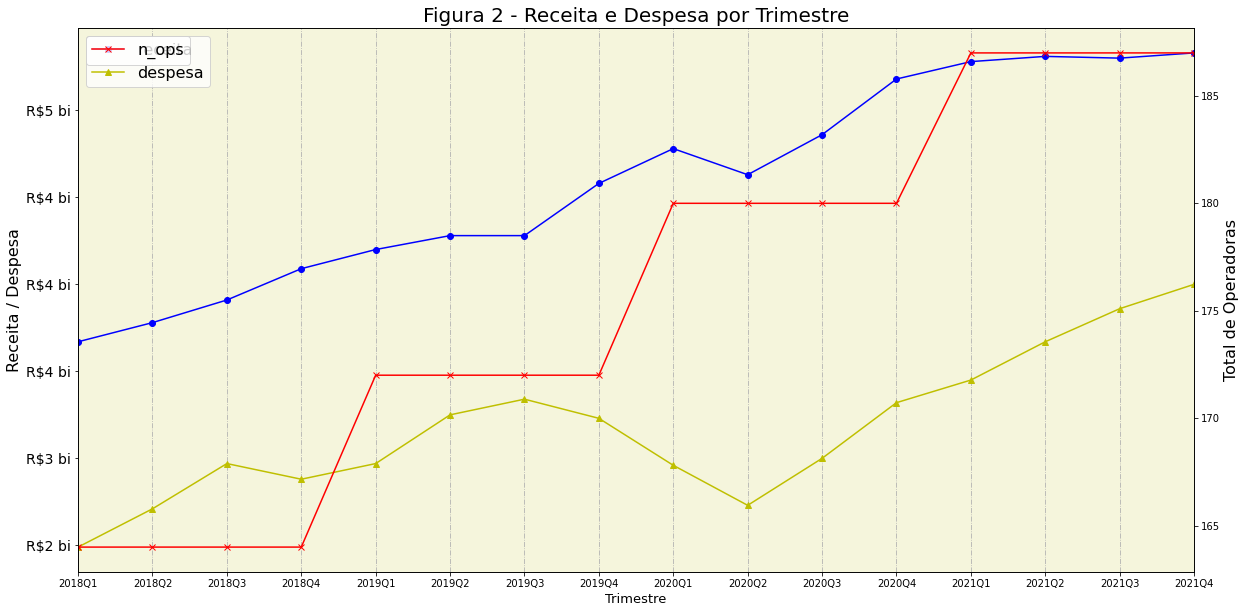

In [89]:
from importlib.metadata import metadata


df_plot = ans_alterada15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('ade_coopmed_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [90]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada16.head()

,ano,cd_ops,receita,despesa
26,2018,326305,3429.430000,3415.230000
3,2018,302147,3025.590000,1970.080000
78,2018,368253,1987.890000,817.320000
63,2018,355097,533.390000,210.900000
11,2018,309222,425.190000,258.790000


In [91]:
ans_alterada_ops = ans_alterada16.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada14.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada16 =  ans_alterada14[i1.isin(i2)]

ans_alterada16.sort_values(by=['receita'], ascending=False, inplace=True)

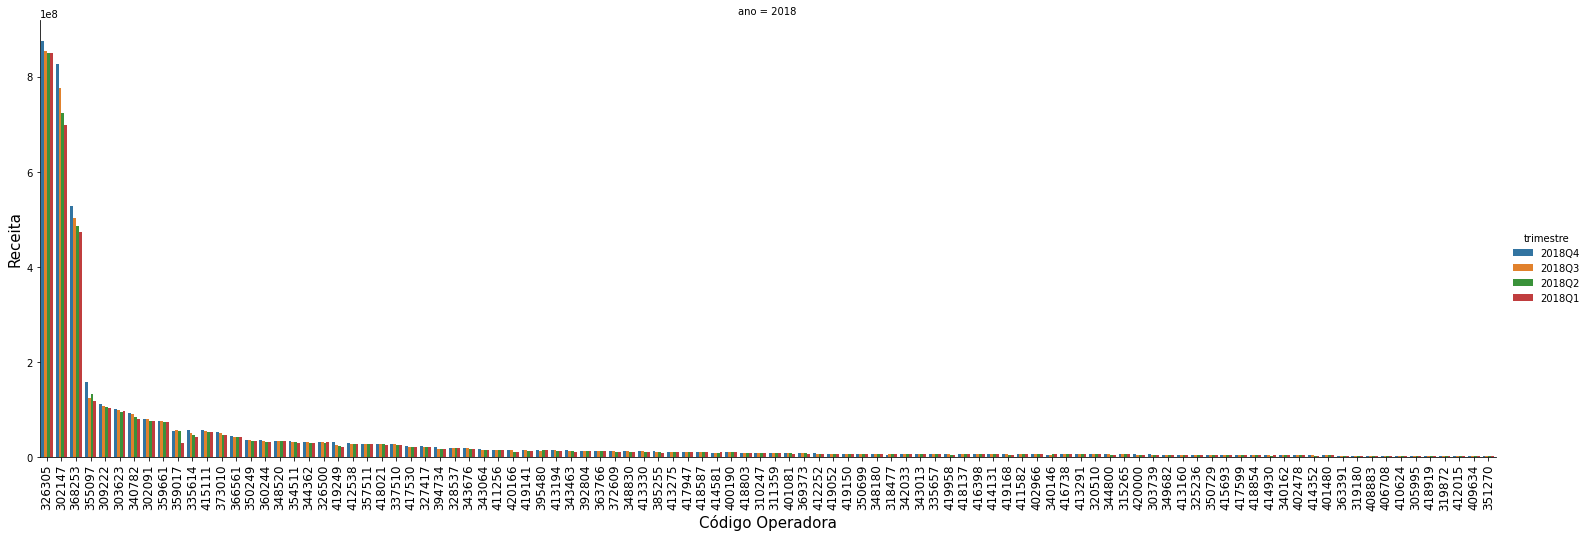

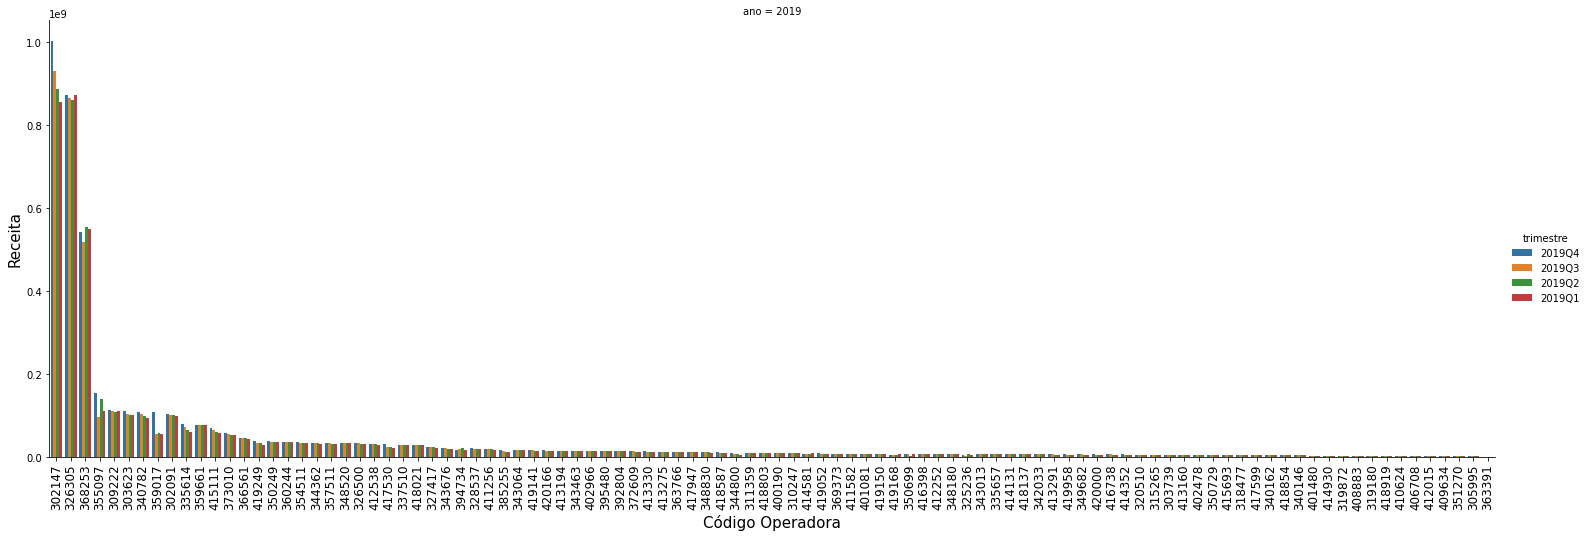

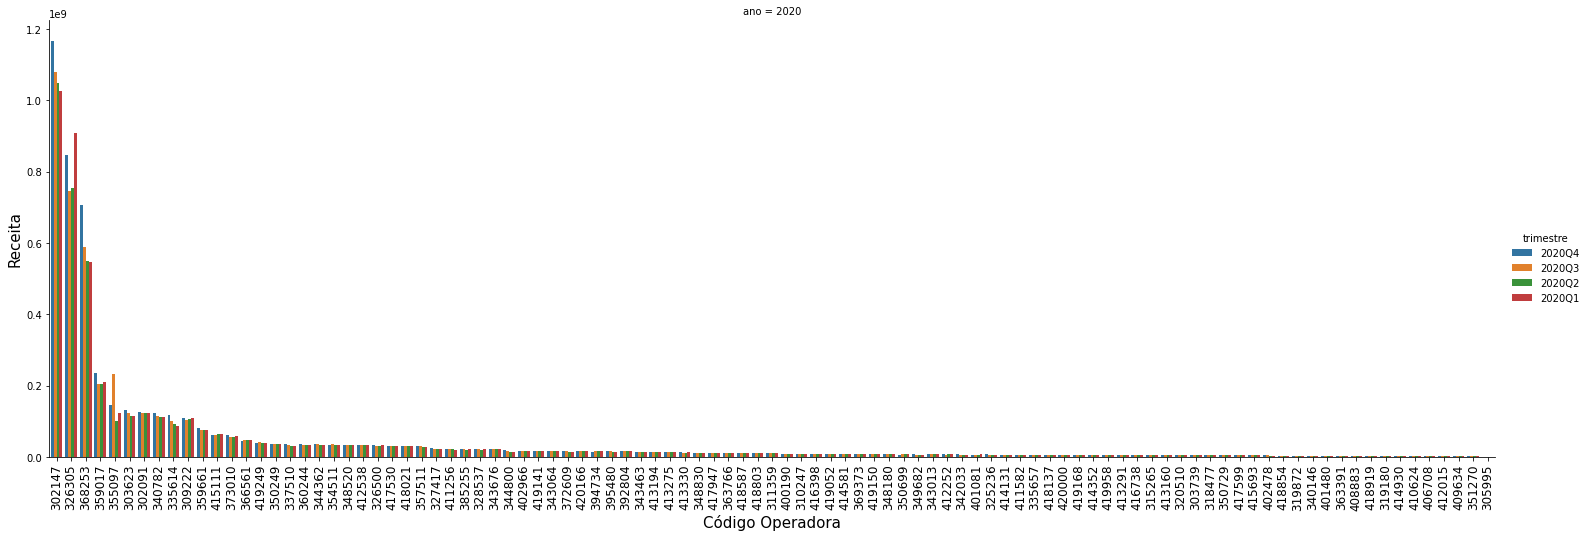

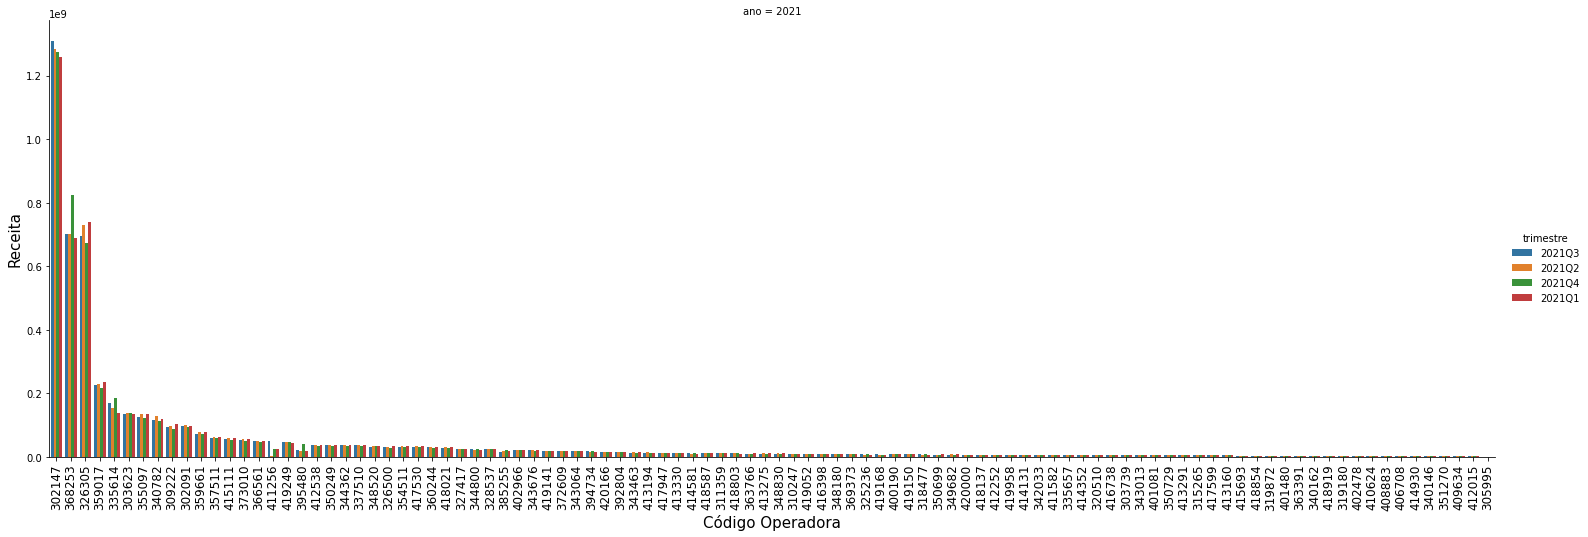

In [92]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

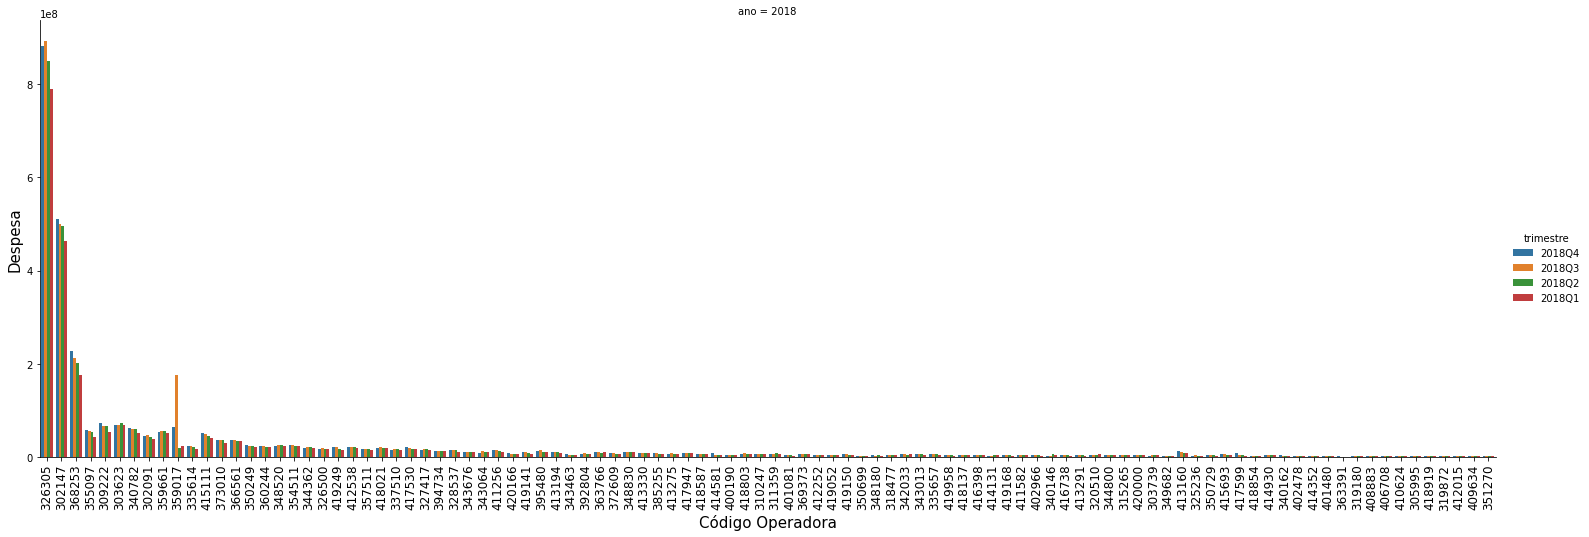

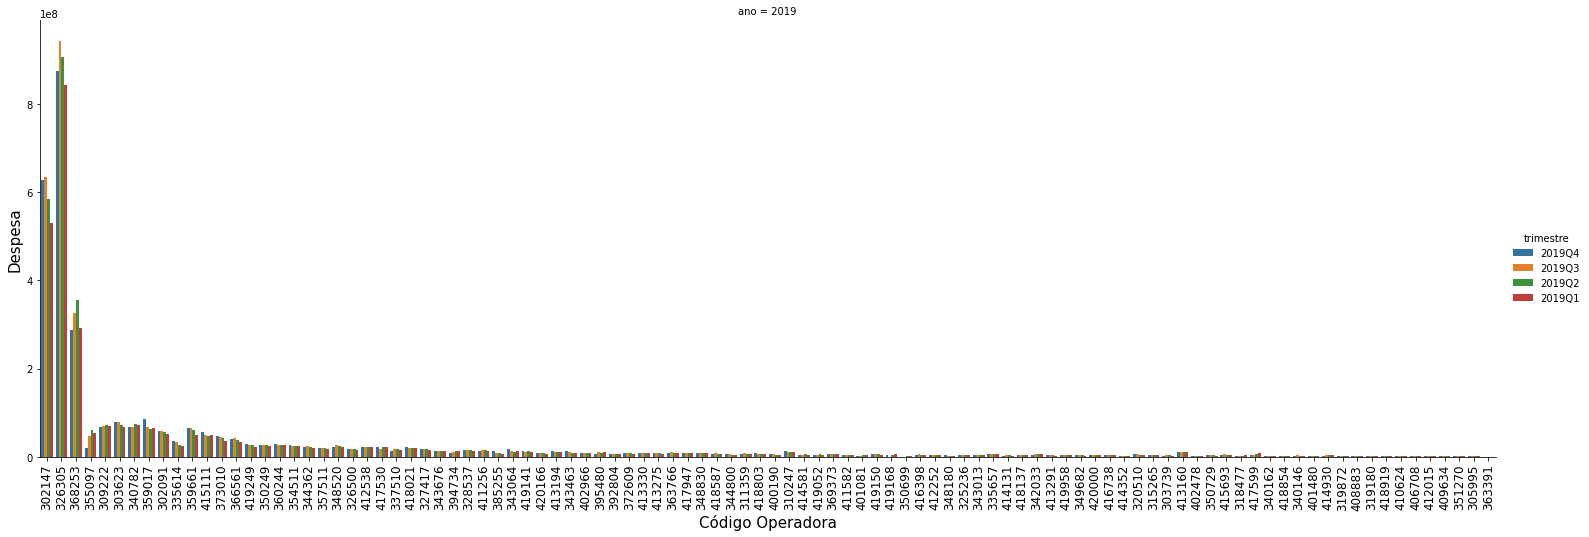

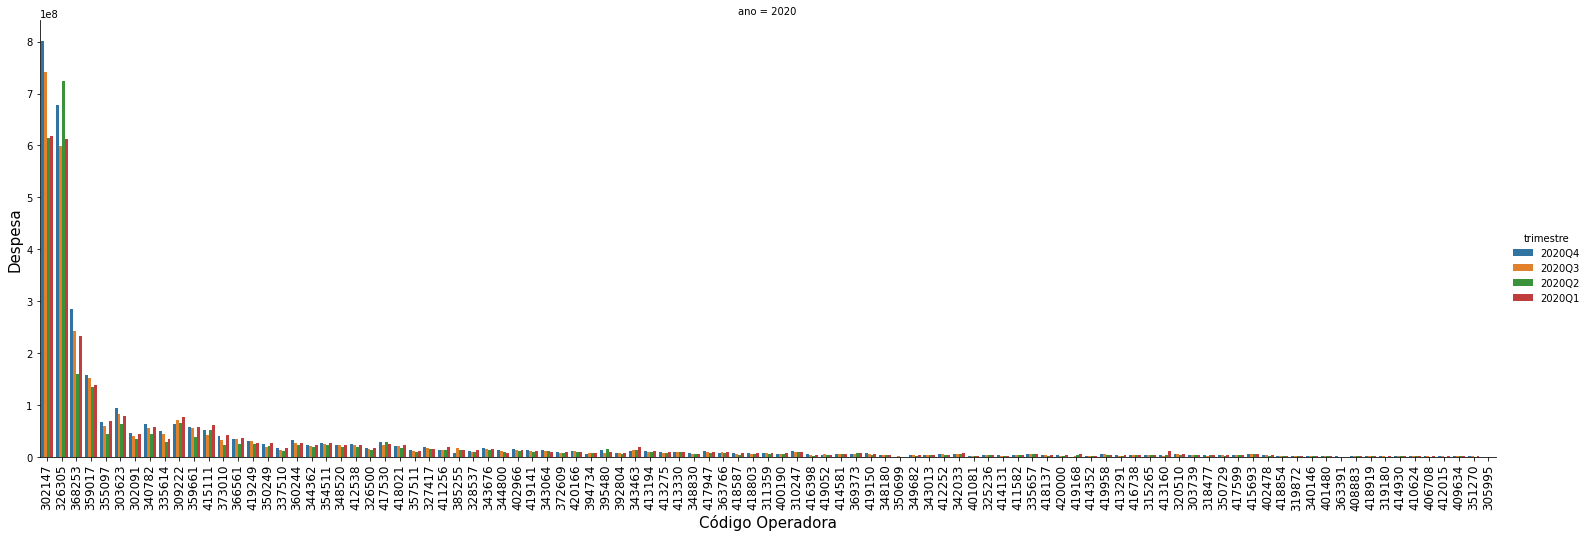

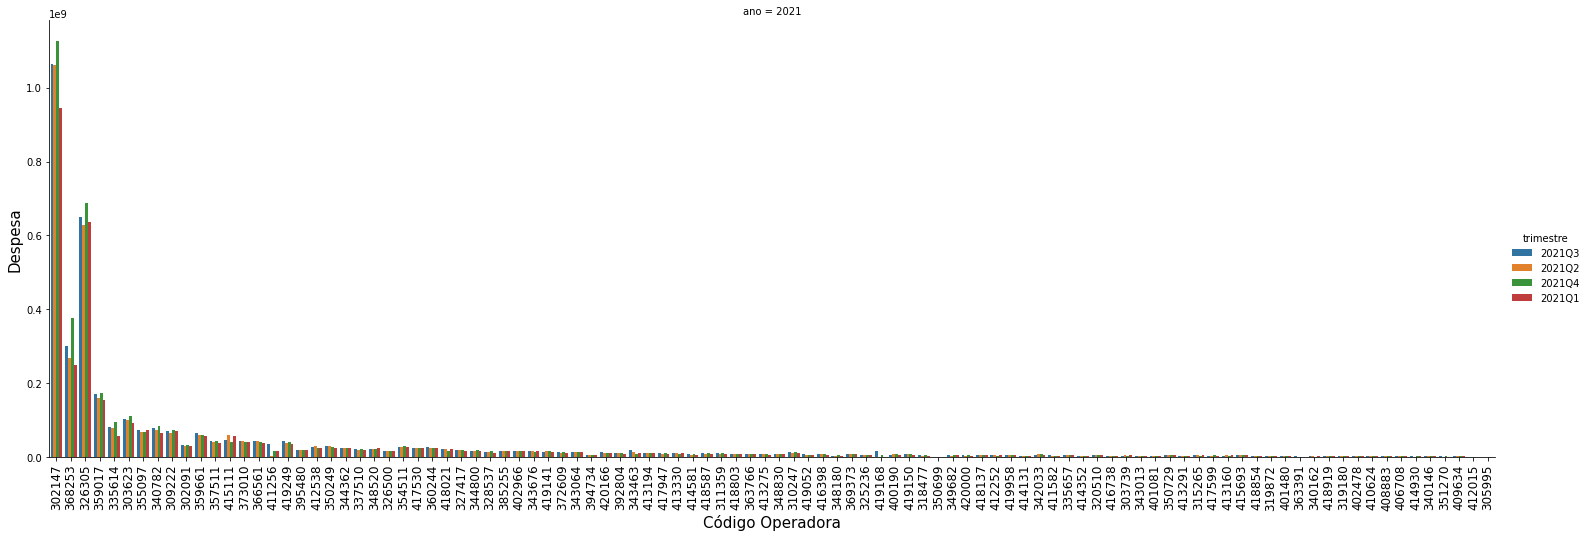

In [93]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

### Merge com a base de beneficiarios

In [94]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\TCC\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [95]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [96]:
filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [97]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.000000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.000000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.500000,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.000000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.000000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.000000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.000000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.000000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.666667,4,3


In [98]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

sib_filtrada = sib_filtrada[(sib_filtrada['contratacao'] == tipo_contratacao)].reset_index(drop=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','trimestre','benef']]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','trimestre'],as_index=False).agg({'benef':'sum'})

sib_filtrada

,ano,cd_ops,trimestre,benef
0,2017,27,2017Q3,631
1,2017,27,2017Q4,614
2,2017,300012,2017Q3,770
3,2017,300012,2017Q4,757
4,2017,300136,2017Q3,4612
...,...,...,...,...
9861,2022,477,2022Q1,2004
9862,2022,5711,2022Q1,17310
9863,2022,6246,2022Q1,17089
9864,2022,701,2022Q1,1729


In [99]:
ans_alterada25 = pd.merge(ans_alterada14,sib_filtrada, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25['modalidade'] = tipo_modalidade

ans_alterada25['contratacao'] = tipo_contratacao

ans_alterada25.to_csv('ind_medgrupo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2018,301728,2018Q1,50926.860000,19552.320000,62.000000
1,2018,301728,2018Q2,11064.770000,18742.630000,61.000000
2,2018,301728,2018Q3,31565.790000,13421.600000,61.000000
3,2018,301728,2018Q4,31871.350000,26065.800000,61.000000
4,2018,302147,2018Q1,697325893.100000,463230201.200000,372087.000000


In [100]:
ans_alterada26 = ans_alterada25.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'benef': 'sum',
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada26['pct_despesa'] = ans_alterada26.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada26.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_alterada26 = ans_alterada26[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_alterada26.to_csv('ind_medgrupo_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada26.set_index('trimestre', inplace=True)

ans_alterada26 

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,3.670000,2.490000,3393738.000000,164,67.850000
2018Q2,3.780000,2.710000,3420266.000000,164,71.690000
2018Q3,3.910000,2.970000,3419047.000000,164,75.960000
2018Q4,4.090000,2.880000,3480800.000000,164,70.420000
2019Q1,4.200000,2.970000,3515622.000000,172,70.710000
2019Q2,4.280000,3.250000,3560458.000000,172,75.930000
2019Q3,4.280000,3.340000,3600781.000000,172,78.040000
2019Q4,4.580000,3.230000,3620468.000000,172,70.520000
2020Q1,4.780000,2.960000,3752896.000000,180,61.920000


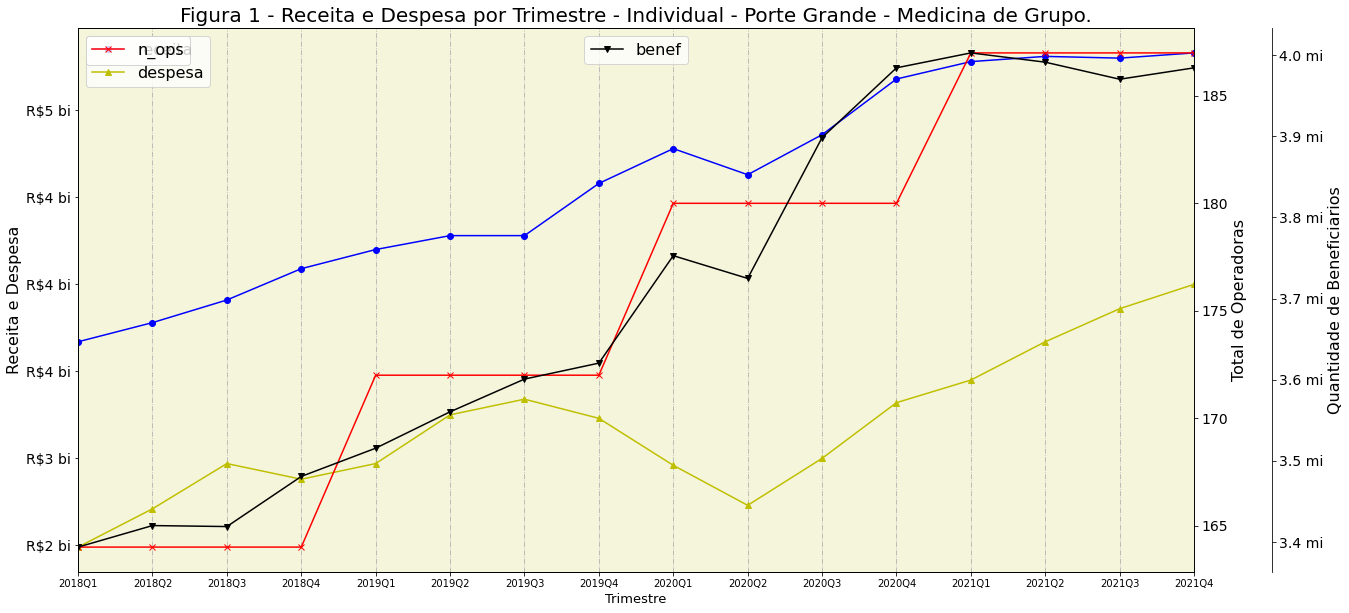

In [101]:
df_plot = ans_alterada26.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Individual - Porte Grande - Medicina de Grupo.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.savefig('ind_medgrupo_02.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

In [102]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada27 = ans_alterada25.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada27.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada27.head()

,ano,cd_ops,receita,despesa
26,2018,326305,3429.430000,3415.230000
3,2018,302147,3025.590000,1970.080000
78,2018,368253,1987.890000,817.320000
63,2018,355097,533.390000,210.900000
11,2018,309222,425.190000,258.790000


In [103]:
ans_alterada_ops = ans_alterada27.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada25.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada28 =  ans_alterada25[i1.isin(i2)]

ans_alterada28.sort_values(by=['receita'], ascending=False, inplace=True)

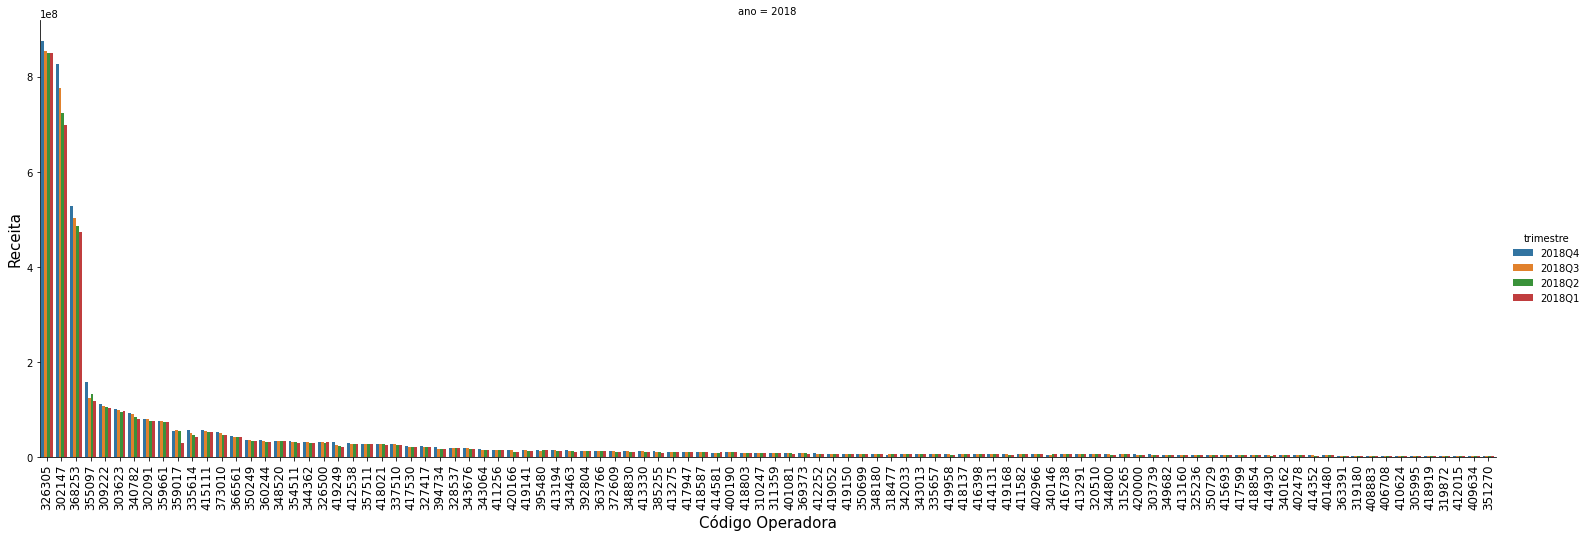

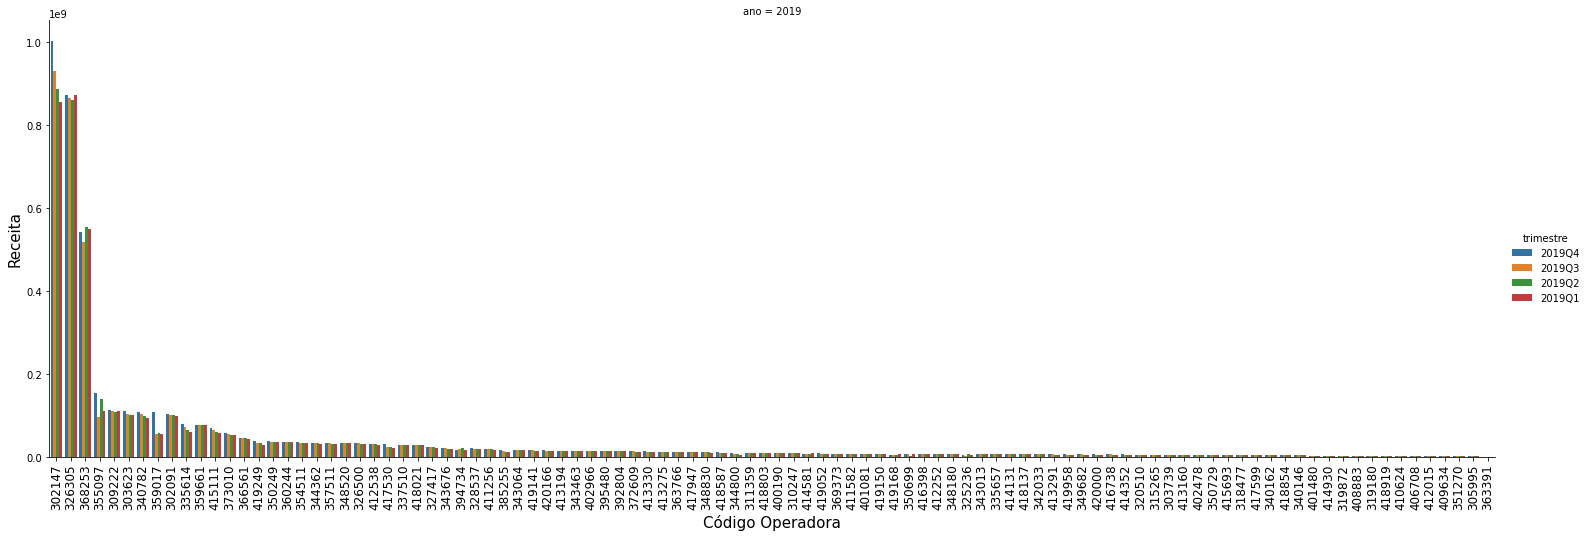

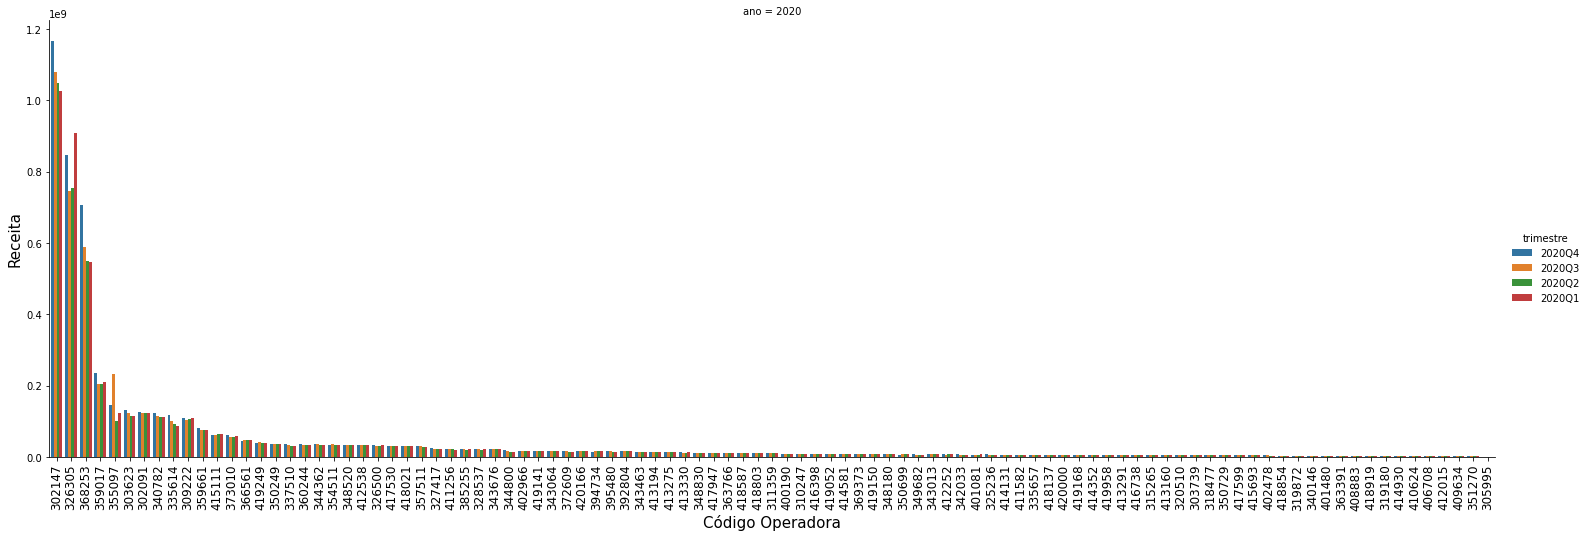

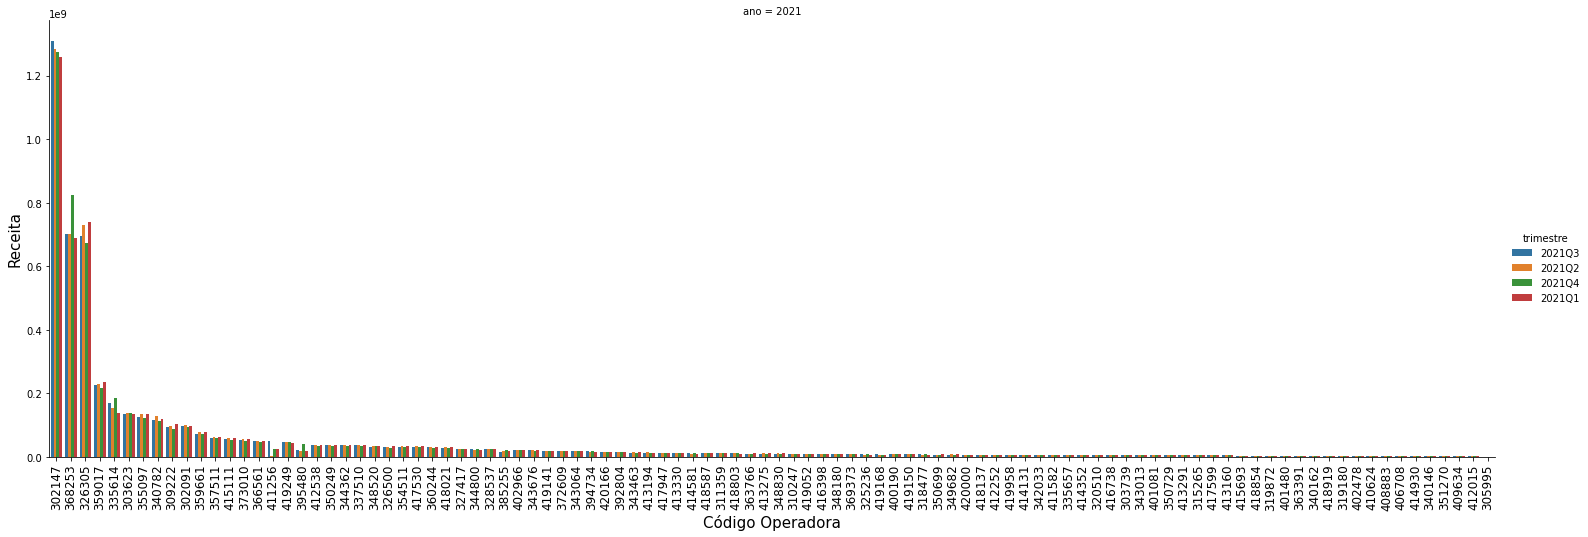

In [104]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

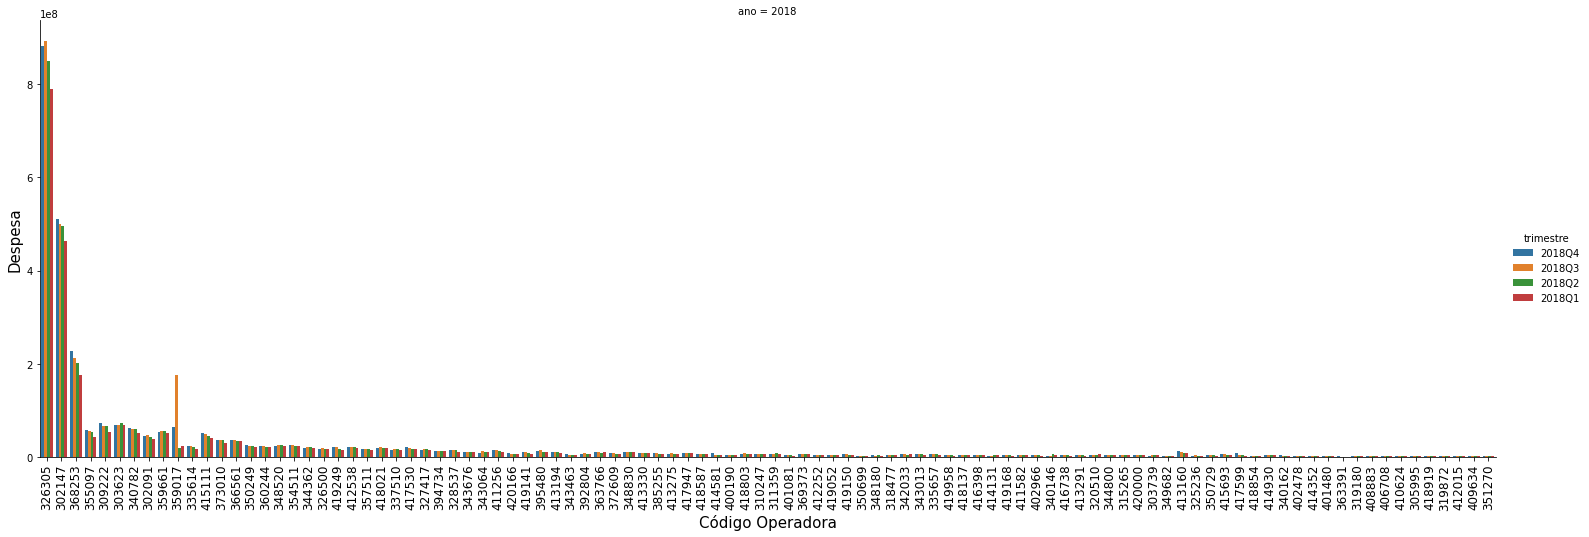

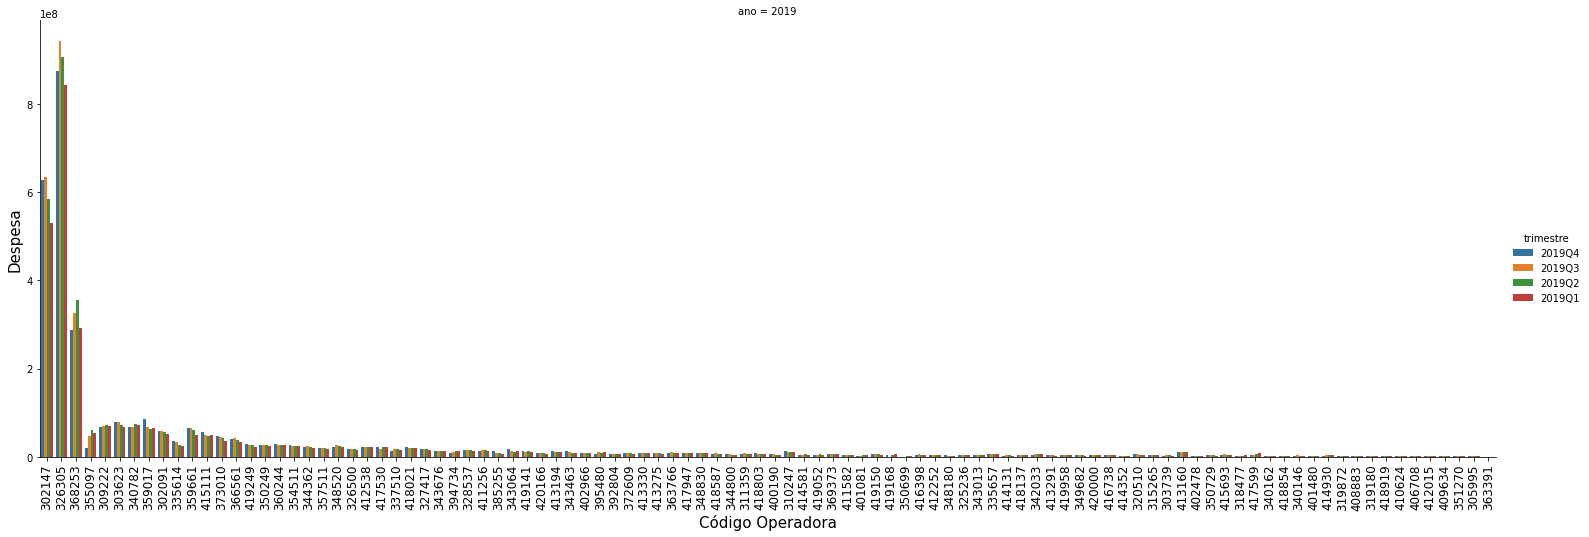

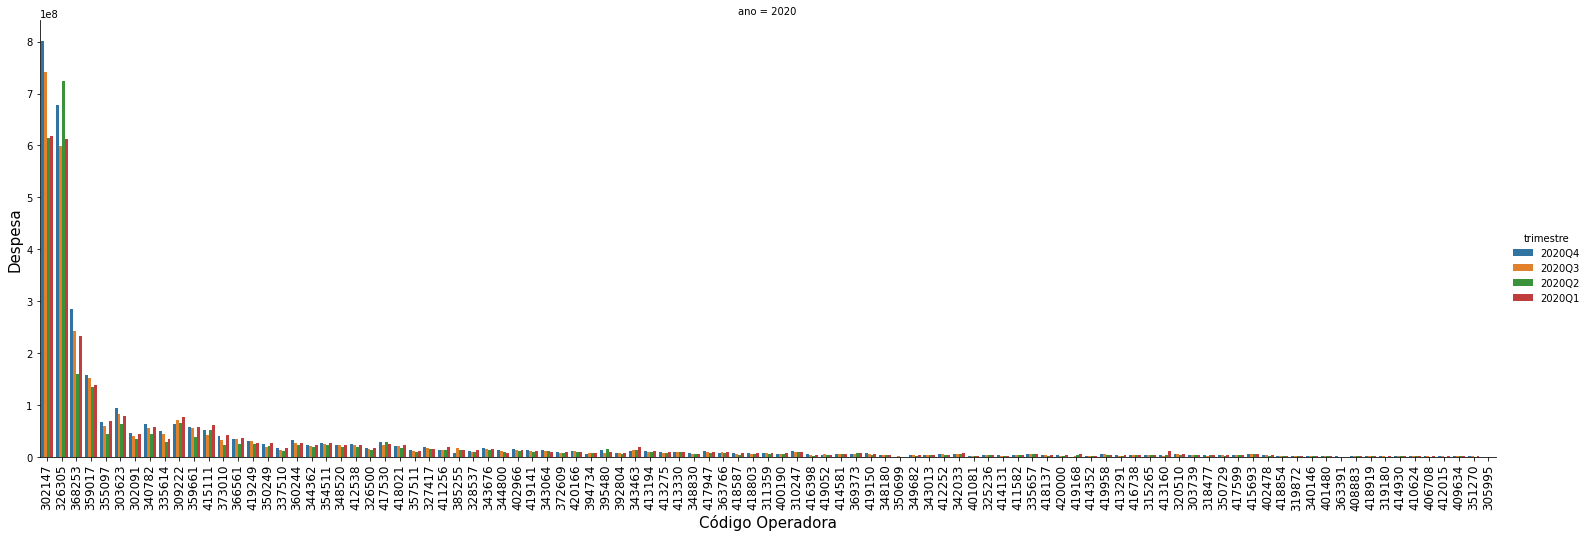

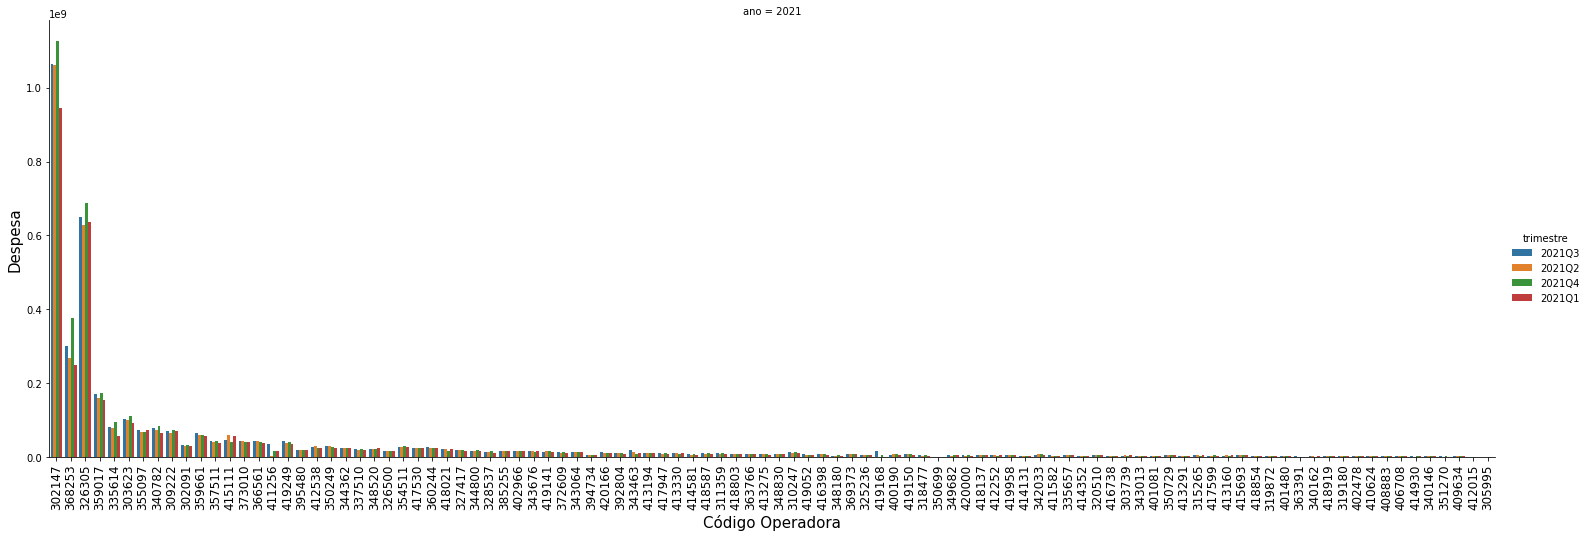

In [105]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot